# Does gender influence who you see as a software engineer?

Introduction goes here

In [1]:
# imports
import pandas as pd
import numpy
from scipy import stats

In [2]:
# grab all the data we need from the db
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/rachel/projects/eng_survey_raw/results.db')
with engine.connect() as conn, conn.begin():
    eng_traits_data = pd.read_sql_table('q1_competent_software_engineer_traits', conn)
    demographics_data = pd.read_sql_table('q31q36_demographics', conn)
    setup_questions_data = pd.read_sql_table('q3q6_setup_questions', conn)

In [3]:
# plots n graphs setup shenanigans
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 20)
plt.rcParams['font.family'] = 'sans-serif'

In [4]:
# constants
FEMALE = "Female" # answer to "What is your gender?
MALE = "Male" # answer to "What is your gender?

# Do women and men see software engineering differently?

An interesting way to slice this data is by people who have CS degrees vs. people who do not. 


In [5]:
# this gets a list of engineering traits so we can pivot on them later
excluded_trait_columns = ('id', 'response_id', 'something_else_writein1', 'something_else_writein2')
eng_traits = [trait for trait in list(eng_traits_data.columns.values) if trait not in excluded_trait_columns]

In [6]:
# Smoosh the right bits of data together. In this case, we want 1) eng traits 
# 2) split out by CS degree 3) by people who identify themselves as engineers 

gender_traits_data = pd.merge(eng_traits_data, 
                           demographics_data[["response_id", "gender"]], 
                           on="response_id", 
                           how="inner",
                           sort=False)
only_software_engineers = setup_questions_data.query("are_you_a_software_engineer == True")

gender_traits_engineers_only_data = pd.merge(gender_traits_data, only_software_engineers[["response_id"]], on="response_id", how="inner", sort=False)

In [7]:
traits_data = pd.pivot_table(gender_traits_engineers_only_data, index=["gender"], values=eng_traits)

# How many traits did people pick? 

The first raw measurement

In [8]:
gender_traits_engineers_only_data['number_selected'] = gender_traits_engineers_only_data[eng_traits].sum(axis=1, numeric_only=True)

In [9]:
number_selected = gender_traits_engineers_only_data['number_selected']

selected_std_dev = numpy.std(number_selected)
selected_mean = numpy.mean(number_selected)
selected_std_dev, selected_mean

(6.430936686434689, 20.727134146341463)

In [11]:
traits_count_by_gender = pd.pivot_table(gender_traits_engineers_only_data, 
                                        index=["gender"], 
                                        values=['number_selected'],
                                        aggfunc=[numpy.mean, numpy.std])
traits_count_by_gender

,mean,std
,number_selected,number_selected
gender,,
Female,20.364964,5.383630
Male,20.781312,6.746099
Other - Write In,19.600000,2.509980
Prefer not to answer,23.272727,4.692354


## What does each group value the highest?

In [12]:
traits_data.stack()[MALE].sort_values(ascending=False)[:10]

logically_work_through_problem     0.938370
write_code_for_others              0.926441
reason_about_other_peoples_code    0.898608
can_admit_mistakes                 0.862823
teamwork                           0.836978
shipping_code                      0.811133
curiousity                         0.809145
can_make_tradeoffs                 0.795229
empathy                            0.771372
data_structures                    0.721670
dtype: float64

In [13]:
traits_data.stack()[FEMALE].sort_values(ascending=False)[:10]

write_code_for_others              0.963504
logically_work_through_problem     0.956204
teamwork                           0.919708
reason_about_other_peoples_code    0.919708
can_admit_mistakes                 0.905109
empathy                            0.868613
curiousity                         0.824818
can_make_tradeoffs                 0.788321
shipping_code                      0.773723
language_features_knowledge        0.729927
dtype: float64

## What do men and women value differently?

The next interesting question is: are there traits each group values more than the other? 


In [14]:
traits_by_gender = traits_data.transpose().filter([FEMALE, MALE])
traits_by_gender['Difference'] = (traits_by_gender[MALE] - traits_by_gender[FEMALE])
traits_by_gender.applymap(lambda x: '%.1f%%' % (x * 100))

gender,Female,Male,Difference
adapability,68.6%,58.6%,-10.0%
advanced_algorithms,12.4%,15.5%,3.1%
can_act_in_crisis,43.1%,35.0%,-8.1%
can_admit_mistakes,90.5%,86.3%,-4.2%
can_handle_disruptions_or_interruptions,38.0%,24.5%,-13.5%
can_learn_quickly,71.5%,64.4%,-7.1%
can_make_tradeoffs,78.8%,79.5%,0.7%
code_structure_skills,71.5%,70.8%,-0.8%
concurrency,53.3%,57.3%,4.0%
curiousity,82.5%,80.9%,-1.6%


In [16]:
traits_difference = traits_by_gender.apply(lambda row: (row[MALE] - row[FEMALE]) * 100,axis=1)


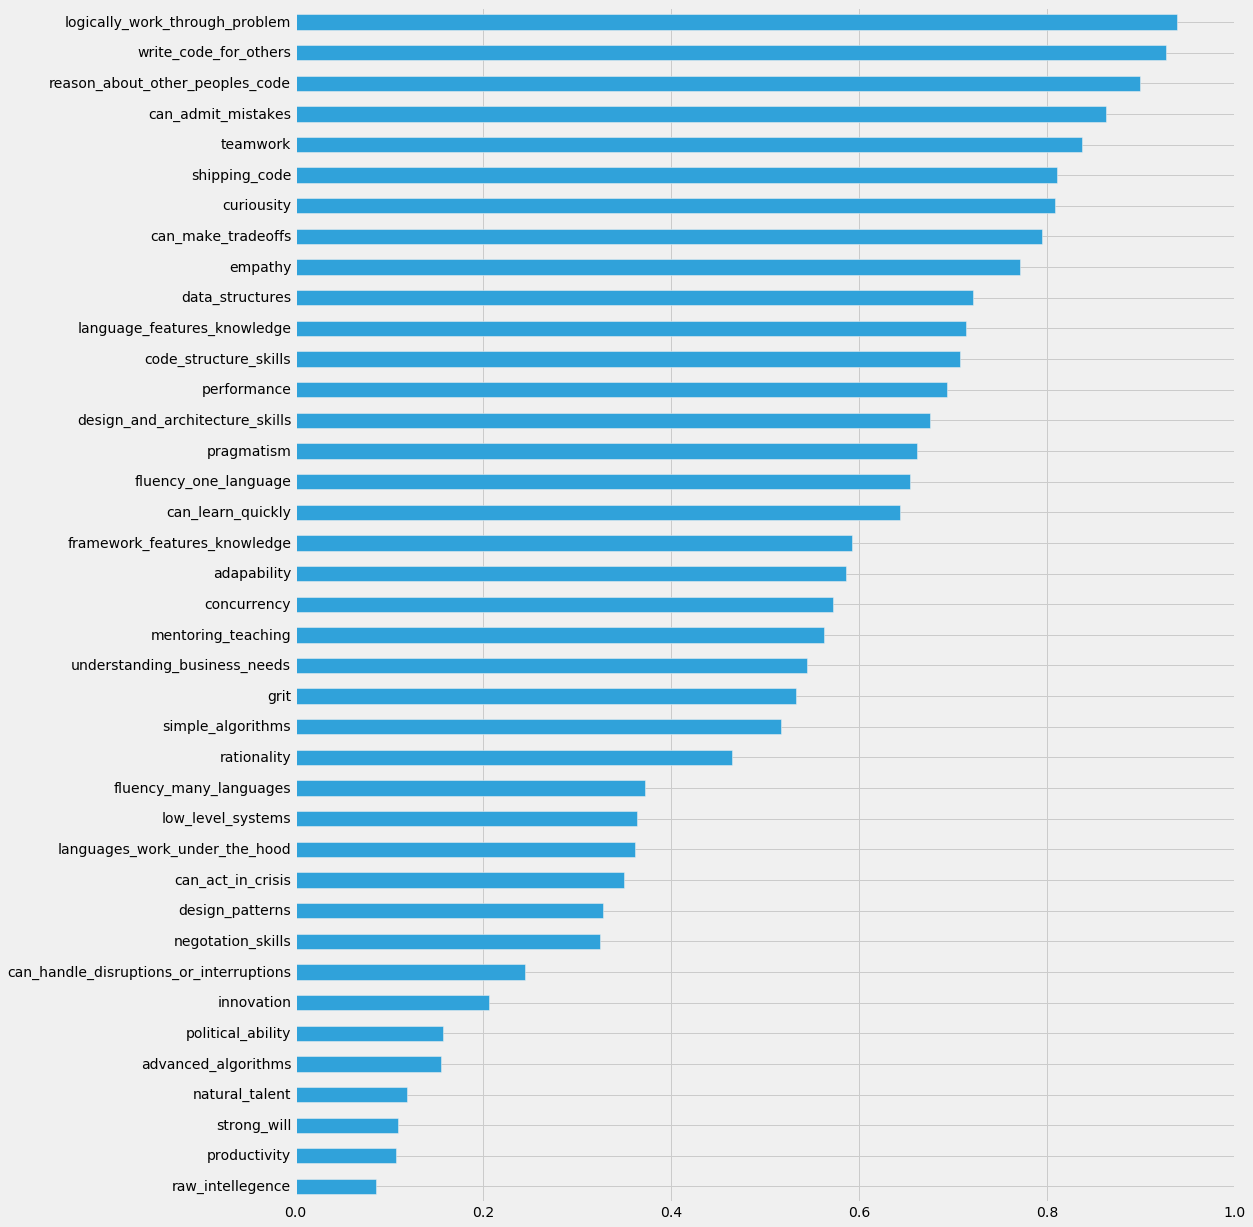

In [18]:
trait_plot2 = traits_data.stack()[MALE].sort_values(ascending=True).plot(kind='barh')
plt.show()

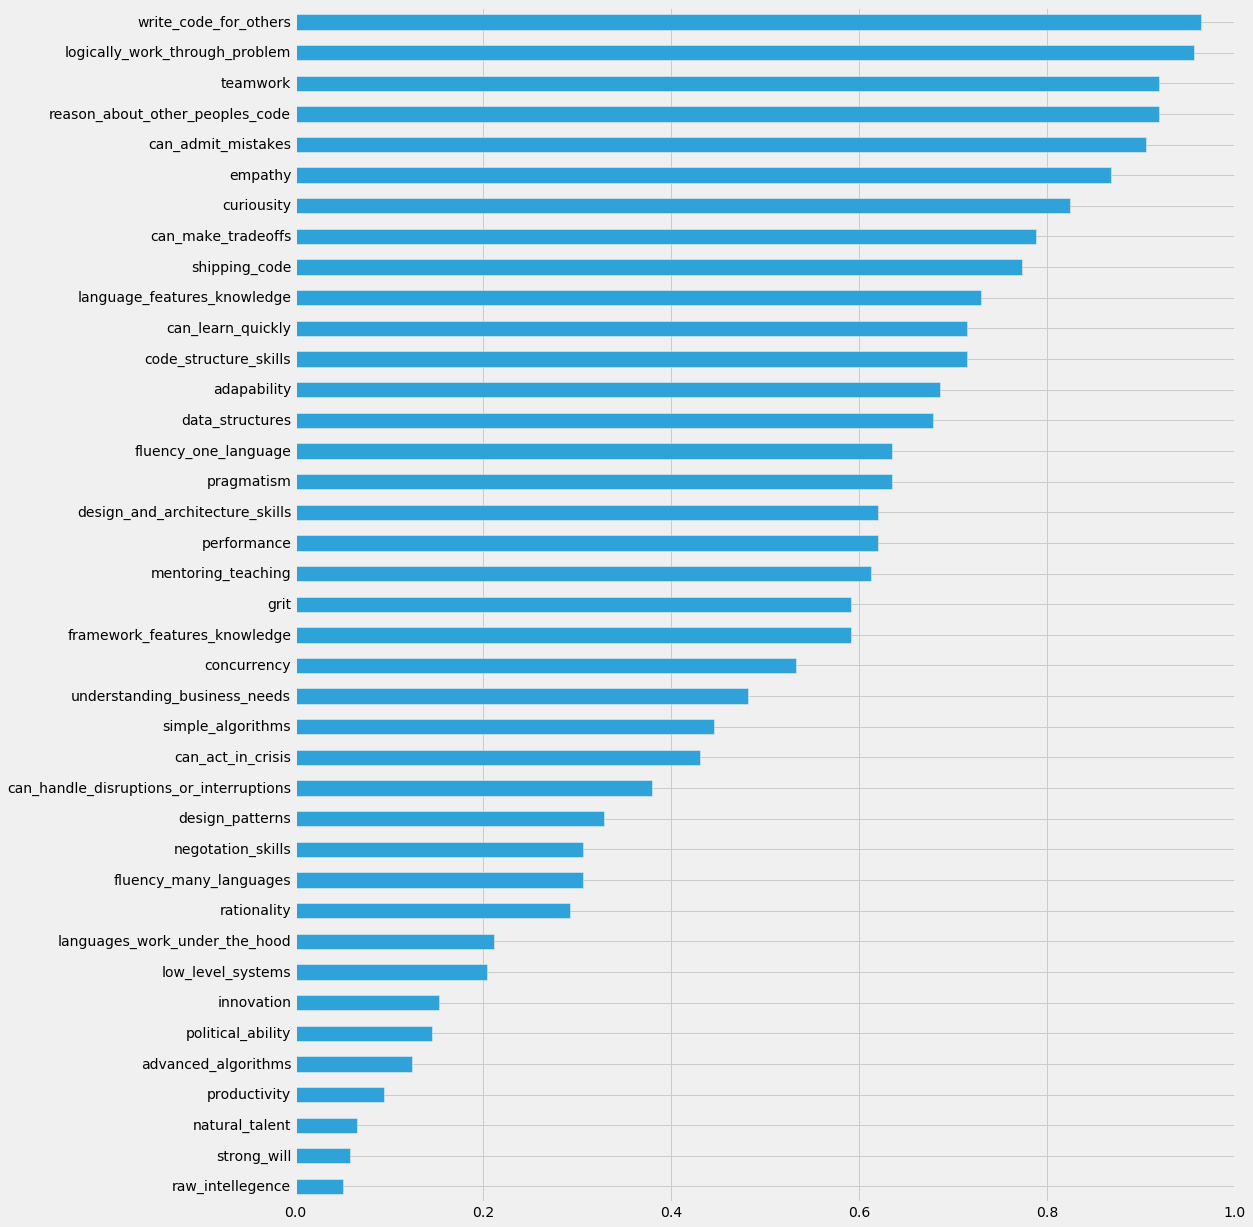

In [19]:
trait_plot3 = traits_data.stack()[FEMALE].sort_values(ascending=True).plot(kind='barh')
plt.show()

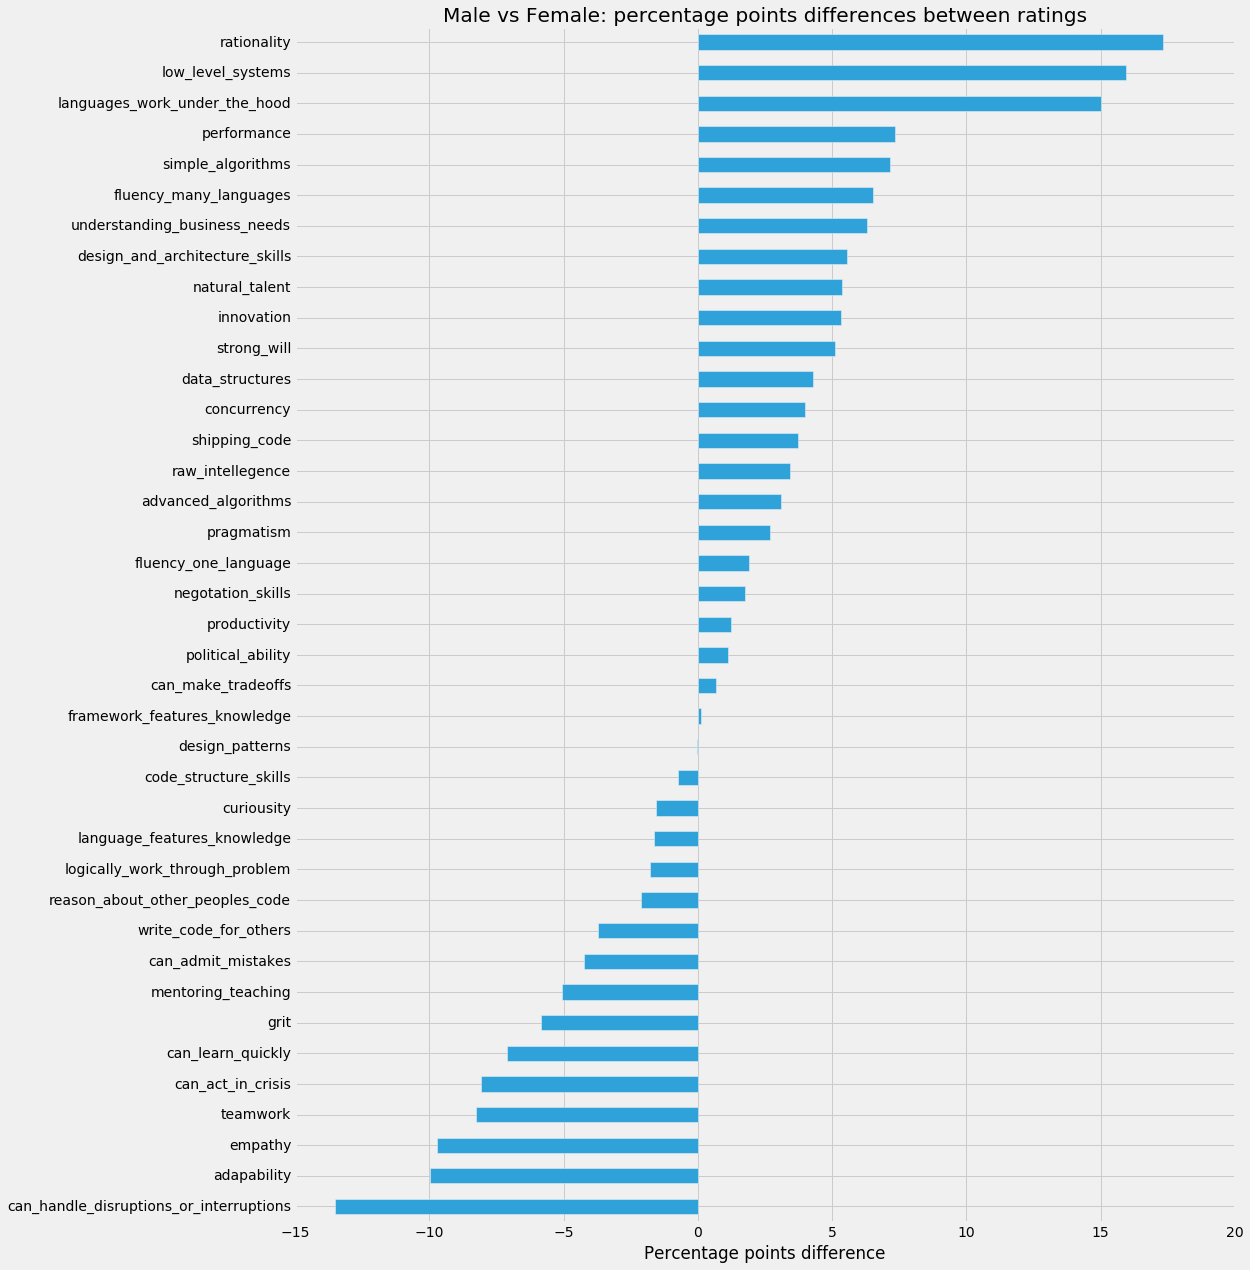

In [20]:
trait_plot = traits_difference.sort_values(ascending=True).plot(kind='barh')
trait_plot.set_title('Male vs Female: percentage points differences between ratings')
trait_plot.set_xlabel('Percentage points difference')

plt.show()

# Statistical significance

trying out t-test here

In [22]:
women_eng_group = gender_traits_engineers_only_data[gender_traits_engineers_only_data['gender'] == FEMALE]
male_eng_group = gender_traits_engineers_only_data[gender_traits_engineers_only_data['gender'] == MALE]

ttest_significance = []
for trait in eng_traits:
    result = stats.ttest_ind(women_eng_group[trait], male_eng_group[trait])
    ttest_significance.append({'trait': trait, 'ttest_statistic': result.statistic, 'pvalue': result.pvalue})
    
ttest = pd.DataFrame(ttest_significance, columns=['trait', 'pvalue', 'ttest_statistic'])

The t-test is supposed to show how likely it is the two groups differ by chance, with the standard threshold being 5% (0.05). The correlation to this is 1 in 20 of these is statistically wrong.

In [23]:
ttest[ttest['pvalue'] <= 0.05].sort_values('pvalue')

,trait,pvalue,ttest_statistic
31,rationality,0.000268,-3.665277
5,low_level_systems,0.000416,-3.548287
6,languages_work_under_the_hood,0.000893,-3.337874
34,can_handle_disruptions_or_interruptions,0.001635,3.163122
22,empathy,0.012845,2.495080
21,teamwork,0.014817,2.443456
35,adapability,0.034221,2.122016
